In [42]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

# animations, etc. requires below magic command
# %matplotlib notebook


"""
Load relevant packages
"""

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import animation, cm

from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

#import autograd
# functions to approx derivative and hessian 
from statsmodels.tools.numdiff import approx_fprime, approx_hess

"""
Own packages
"""

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## A brief look at Ordinary Least Squares (OLS)

We will write a linear regression model (using matrix notation) as 

$$
\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \mathbf{e}
$$

where $\mathbf{y}$ is the $n \times 1$ vector of dependent variables, $\mathbf{X}$ is the $n \times k$ matrix of regressors (independent variables) and $\mathbf{e}$ is the $n \times 1$ error vector. 

As the name implies, the OLS estimator minimizes the sum of squared residuals 

$$
Q_n (\boldsymbol{\beta}) = \sum_{i=1}^n (y_i - \mathbf{x}_i^\top \boldsymbol{\beta} )^2 = (\mathbf{y} - \mathbf{X}\boldsymbol{\beta})^\top (\mathbf{y} - \mathbf{X}\boldsymbol{\beta}) = \mathbf{e}^\top \mathbf{e}
$$

Taking the derivative wrt. $\boldsymbol{\beta}$ and setting equal to zero yields the estimator 

$$
\hat{\boldsymbol{\beta}}_{OLS} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$$


### Properties of OLS

__Note__: It is not expected that you know all the finer details in deriving the asymptotic properties of e.g. the OLS estimator, but only how to implement derived formulas in Python. 

__Consistency__

$$
\begin{align}
\hat{\boldsymbol{\beta}}_{OLS} &= (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y} \\
&= (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top (\mathbf{X}\boldsymbol{\beta} + \mathbf{e}) \\
&= (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{X}\boldsymbol{\beta} + (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{e} \\
&= \boldsymbol{\beta} + (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{e} \\
&= \boldsymbol{\beta} + \left(\frac{1}{n}\mathbf{X}^\top \mathbf{X}\right)^{-1} \frac{1}{n}\mathbf{X}^\top \mathbf{e} 
\end{align}
$$

Basically, for consistency we need (without going into details)

$$
\text{plim} \frac{1}{n}\mathbf{X}^\top \mathbf{X} = \lim \frac{1}{n} \text{E} \left[ \mathbf{X}^\top\mathbf{X} \right]  =  \mathbf{M_{xx}}
$$

where $\mathbf{M_{xx}}$ is a non-singular matrix (invertible), and 

$$
\text{plim} \frac{1}{n}\mathbf{X}^\top \mathbf{e} =  \lim \frac{1}{n} \text{E} \left[ \mathbf{X}^\top\mathbf{e} \right] =\mathbf{0}
$$

requiring the regressors and error term to be uncorrelated. 

__Asymptotic normality__

Rewritting the above expression yields 

$$
\sqrt{n}(\hat{\boldsymbol{\beta}}_{OLS} - \boldsymbol{\beta}) = \left(\frac{1}{n}\mathbf{X}^\top \mathbf{X}\right)^{-1} \frac{1}{\sqrt{n}}\mathbf{X}^\top \mathbf{e} 
$$

If we can apply a CLT to $\frac{1}{\sqrt{n}}\mathbf{X}^\top \mathbf{e}$ such that it converges to multivariate normal distribution with finite, non-singular covariance matrix, we will have asymptotic normality. 

Assuming that 

$$
\frac{1}{\sqrt{n}}\mathbf{X}^\top \mathbf{e} \to^d N(\mathbf{0}, \mathbf{M_{x\Omega x}})
$$

with  (here $\boldsymbol{\Omega}=\text{E}[\mathbf{e} \mathbf{e}^\top \vert \mathbf{X}] = \text{Diag}[\sigma_i^2]$ is the covariance matrix of the errors)

$$
\text{plim} \frac{1}{n}\mathbf{X}^\top \mathbf{e} \mathbf{e}^\top\mathbf{X} = \text{plim} \frac{1}{n}\mathbf{X}^\top  \boldsymbol{\Omega} \mathbf{X}  = \mathbf{M_{x\Omega x}}
$$

then it will be possible to show that 

$$
\sqrt{n}(\hat{\boldsymbol{\beta}}_{OLS} - \boldsymbol{\beta}) \to^d N\left(\mathbf{0}, \mathbf{M_{xx}}^{-1} \mathbf{M_{x\Omega x}}\mathbf{M_{xx}}^{-1}\right)
$$

__Homoskedasticity vs. heteroskedasticity__

If $\boldsymbol{\Omega}=\text{E}[\mathbf{e}^\top \mathbf{e} \vert \mathbf{X}] = \text{Diag}[\sigma^2] = \sigma^2 \mathbf{I}$ then the error term is said to be homoskedastic and 

$$
\sqrt{n}(\hat{\boldsymbol{\beta}}_{OLS} - \boldsymbol{\beta}) \to^d N\left(\mathbf{0}, \sigma^2 \mathbf{M_{xx}}^{-1} \mathbf{M_{xx}}\mathbf{M_{xx}}^{-1}\right) = N\left(\mathbf{0}, \sigma^2 \mathbf{M_{xx}}^{-1} \right) 
$$

where we will estimate $\hat{\mathbf{M}}_{\mathbf{xx}} = \frac{1}{n} \mathbf{X}^\top\mathbf{X}$ and $\sigma^2$ using the sample variance. 

$$
S^2 = \frac{1}{n - k} \hat{\mathbf{e}}^\top \hat{\mathbf{e}}
$$

This leads to the variance estimator of the OLS estimator

$$
\hat{\text{Var}}[\hat{\boldsymbol{\beta}}_{OLS}] = S^2 \left( \mathbf{X}^\top\mathbf{X} \right)^{-1}
$$

If the error term is heteroskedastic then $\sigma_i^2$ differs between observations. [Heteroscedastic robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors) can be obtained using (under some regularity conditions)

$$
\hat{\text{Var}}[\hat{\boldsymbol{\beta}}_{OLS}] = \left( \mathbf{X}^\top\mathbf{X} \right)^{-1} \mathbf{X}^\top \hat{\boldsymbol{\Omega}}\mathbf{X} \left( \mathbf{X}^\top\mathbf{X} \right)^{-1}
$$

where $\hat{\boldsymbol{\Omega}} = \text{Diag}[\hat{e}_i^2]$. 

## A general framework: m-estimators 

In financial economics we cannot solely rely on linear regressions, we also need to be able to estimate parameters of different densities or highly non-linear models. 

Some of the principles observed for OLS can be extended to more general type of estimators namely [m-estimators](https://en.wikipedia.org/wiki/M-estimator) that includes _Non-linear Least Squares (NLS)_ and _Maximum Likelihood Estimation (MLE)_. 

### Definition of m-estimator

A m-estimator $\hat{\theta}$ of the $k \times 1$ parameter vector $\theta$ minimizes the objective function $Q_n(\theta)$ that can be written as a sample average

$$
Q_n(\theta) = \frac{1}{n} \sum_{i=1}^n q(y_i, \mathbf{x}_i; \theta)
$$
where $q(\cdot)$ is scalar function. We assume independence over $i$.  

Clearly, with $q(y_i, \mathbf{x}_i; \beta) = (y_i - \mathbf{x}_i^\top \beta)^2$ OLS is a m-estimator!  The m-estimator is computed as the solution to the FOC 

$$
\left. \frac{\partial Q_n(\theta)}{\partial \theta} \right \vert _{\theta = \hat{\theta}} = \frac{1}{n} \sum_{i=1}^n \left. \frac{\partial q_i(y_i, \mathbf{x}_i ;\theta)}{\partial \theta} \right \vert _{\theta = \hat{\theta}} = \mathbf{0}
$$

The $k$ equations with $k$ unknowns will sometimes have an explicit analytical solution, but often we need to use numerical methods to find a solution. 

### Some comments on properties of m-estimators

Generally, it can be an audacious task to derive the properties of m-estimators such as NLS and MLE and it is not the objective of the course. 

__Consistency__

We have to assume that there is a particular data generating process and a corresponding value of $\theta$, say $\theta_0$, which generates the data. We need to have that $\theta_0$ is unique in the sense that other values of $\theta$ would not correspond to the same data-generating proces ([identification](https://en.wikipedia.org/wiki/Identifiability)). 

In a linear regression model this holds when $\mathbf{X}$ has full rank since then 

$$
\mathbf{x}^\top \beta_1 = \mathbf{x}^\top \beta_2
$$

if and only if $\beta_1=\beta_2$. 

__Limit distribution__

As in the case for OLS, the m-estimators that we consider will typically converge asymptotically to a multivariate normal

$$
\sqrt{n} (\hat{\theta} - \theta_0) \to^d N(0, \mathbf{A}_0^{-1} \mathbf{B} \mathbf{A}_0^{-1})
$$

where 

$$
\mathbf{A}_0 = \text{plim} \frac{1}{n} \sum_{i=1}^n \left. \frac{\partial^2 q_i(y_i, \mathbf{x}_i ;\theta)}{\partial \theta \partial \theta^\top} \right \vert _{\theta = \theta_0} = \text{lim} \frac{1}{n} \sum_{i=1}^n \text{E} \left[\left. \frac{\partial^2 q_i(y_i, \mathbf{x}_i ;\theta)}{\partial \theta \partial \theta^\top} \right \vert _{\theta = \theta_0} \right]
$$

and 

$$
\mathbf{B}_0 = \text{plim} \frac{1}{n} \sum_{i=1}^n \left. \frac{\partial q_i(y_i, \mathbf{x}_i ;\theta)}{\partial \theta } \frac{\partial q_i(y_i, \mathbf{x}_i ;\theta)}{\partial \theta^\top } \right \vert _{\theta = \theta_0} = \text{lim} \frac{1}{n} \sum_{i=1}^n \text{E} \left[\left. \frac{\partial q_i(y_i, \mathbf{x}_i ;\theta)}{\partial \theta } \frac{\partial q_i(y_i, \mathbf{x}_i ;\theta)}{\partial \theta^\top } \right \vert _{\theta = \theta_0} \right]
$$

__The OLS case__

We note that for OLS, we would have

$$
\begin{align}
\mathbf{A}_0 & =  \lim \frac{1}{n} \text{E} \left[ \mathbf{X}^\top\mathbf{X} \right]  =  \mathbf{M_{xx}} \\
\mathbf{B}_0 & = \lim \frac{1}{n} \text{E} \left[ \mathbf{X}^\top \mathbf{e} \mathbf{e}^\top\mathbf{X}   \right]  = \mathbf{M_{x\Omega x}}
\end{align}
$$

such that we obtain the asymptotic distribution presented above. To see this, remember that (the constant 2 will disappear when calculating the asymptotic variance)

$$
\frac{\partial}{\partial \beta }  (y_i - \mathbf{x}_i^\top \beta)^2 = 2 (y_i - \mathbf{x}_i^\top \beta) \mathbf{x}_i = 2e_i \mathbf{x}_i
$$

such that 

$$
\frac{1}{n} \sum_{i=1}^n \frac{\partial}{\partial \beta }  (y_i - \mathbf{x}_i^\top \beta)^2 \frac{\partial}{\partial \beta^\top }  (y_i - \mathbf{x}_i^\top \beta)^2 = \frac{1}{n} \sum_{i=1}^n 4e_i^2 \mathbf{x}_i \mathbf{x}_i^\top = \frac{1}{n} 4 \mathbf{X}^\top \mathbf{e} \mathbf{e}^\top \mathbf{X}
$$

and 

$$
\frac{1}{n} \sum_{i=1}^n \frac{\partial}{\partial \beta \partial \beta^\top}  (y_i - \mathbf{x}_i^\top \beta)^2 = \frac{1}{n} \sum_{i=1}^n 2 \mathbf{x}_i \mathbf{x}_i^\top = \frac{1}{n} 2 \mathbf{X}^\top\mathbf{X}
$$

__Approximating the limit distribution__

We also note that we could use the below estimators when approximating the limit distribution 

$$
\begin{align}
\hat{\mathbf{A}} & = \frac{1}{n} \sum_{i=1}^n \left. \frac{\partial^2 q_i(y_i, \mathbf{x}_i ;\theta)}{\partial \theta \partial \theta^\top} \right \vert _{\theta = \hat{\theta}}  \\
\hat{\mathbf{B}} & = \frac{1}{n} \sum_{i=1}^n \left. \frac{\partial q_i(y_i, \mathbf{x}_i ;\theta)}{\partial \theta } \frac{\partial q_i(y_i, \mathbf{x}_i ;\theta)}{\partial \theta^\top } \right \vert _{\theta = \hat{\theta}}
\end{align}
$$

## Maximum likelihood estimation (MLE)

[Maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) is one of the most widely used estimation methods with a number of diserable properties, e.g. it will be the most efficient estimator among consistent asymptotically normal estimators. 

The MLE of $\theta_0$ basically seeks to select the $\theta$ that maximizes the likelihood of observing the actual sample. The joint density of the random sample $f(\mathbf{y}, \mathbf{X}; \theta)$, which will define as the likelihood function, can under an independence assumption be written as the product of the marginal densities 

$$
L_n (\theta \vert \mathbf{y}, \mathbf{X}) = f(\mathbf{y}, \mathbf{X}; \theta) = \prod_{i=1}^n f_{y, \mathbf{x}_i} (y_i, \mathbf{x}_i; \theta)
$$

Since $\ln$ is a positive monotone transformation, we can equivalently maximize the log-likelihood function 

$$
\mathcal{L}_n (\theta \vert \mathbf{y}, \mathbf{X}) = \ln L_n (\theta \vert \mathbf{y}, \mathbf{X}) = \sum_{i=1}^n \ln f_{y, \mathbf{x}_i} (y_i, \mathbf{x}_i; \theta)
$$


### Conditional likelihood

We can factorize a density as the product between the conditional and marginal density

$$
L_n (\theta \vert \mathbf{y}, \mathbf{X}) = f(\mathbf{y}, \mathbf{X}; \theta) = f(\mathbf{y} \vert \mathbf{X}; \theta) f(\mathbf{X}; \theta)  
$$

Typically, we will only focus on the conditional density $f(\mathbf{y} \vert \mathbf{X}; \theta)$ since we are interested in $\mathbf{y}$ given $\mathbf{X}$ (we will do this below). It will not be an issue if $\mathbf{y}$ and $\mathbf{X}$ depends on different sets of parameters, which often will be a reasonable assumption (but not always). 

In _time series modelling_, we also often use the notion of a conditional likelihood function since we cannot always apply an independence assumption.  Assume e.g. that $y_t$ depends on $y_{t-1}$ (and no regressors) then we could factorize (using T to indicate time series context)

$$
\begin{align}
L_T (\theta \vert \mathbf{y}) &= f_{y_0, \dots, y_T}(y_0, \dots, y_T; \theta) \\
&= f_y(y_0; \theta) f_{y_1, \dots, y_T}(y_1, \dots, y_T; \theta) \\
&= f_y(y_0; \theta) \prod_{t=1}^T f_{y_t \vert y_{t-1}}(y_t \vert y_{t-1}; \theta)
\end{align}
$$

dropping $f_y(y_0; \theta)$ will result in the conditional likelihood function that is conditional on the starting value. 

### M-estimator

In order to be able to use the results for m-estimators, we just divide the log-likelihood function with $n$

$$
Q_n(\theta) = \frac{1}{n} \mathcal{L}_n (\theta) = \frac{1}{n} \sum_{i=1}^n \ln f_{y, \mathbf{x}_i} (y_i \vert \mathbf{x}_i; \theta)
$$

__Remember:__ Most optimizers seek to minimize a function so we may need to multiply with minus one and then minimize. 

__Example: Bernoulli__

Assume that we observe a realization of the random sample $Y_1, ...., Y_{n}$ where $Y_i\sim \text{Bernoulli}(p), i=1,...,n$  

We can write the likelihood function as 

$$
\begin{equation*}
L(p) = \prod_{i=1}^n f_Y(y_i;p) = \prod_{i=1}^n p^{y_i}(1-p) ^{1-y_i} = p^{\sum_{i=1}^n y_i}(1-p)^{\sum_{i=1}^n (1-y_i)}
\end{equation*}
$$

We want to maximize with respect to $p$, but we first take the natural logarithm 

$$
\begin{equation*}
\ln L(p) = \ln (p) \sum_{i=1}^n y_i + \ln(1-p) \sum_{i=1}^n (1-y_i)
\end{equation*}
$$

The first order condition is (take derivative wrt. $p$)

$$
\begin{equation*}
\frac{1}{p} \sum_{i=1}^n y_i - \frac{1}{1-p} \left[n - \sum_{i=1}^n y_i \right] = 0
\end{equation*}
$$

such that we obtain the maximum-likelihood estimate

$$
p_e = \frac{1}{n}\sum_{i=1}^n y_i
$$

Below, we see a simple implementation in Python

In [43]:
"""
Define log-likelihood function
"""

def log_likelihood_function(p, x):
    
    log_like = np.log(p) * np.sum(x) + np.log(1-p) * np.sum(1-x)
    
    return log_like

"""
Generate data
"""
np.random.seed(5)
bernoulli_data = np.random.binomial(1,0.5,size=20)

"""
Minimize negative of log-likelihood
"""
neg_log_lik = lambda p: -log_likelihood_function(p, bernoulli_data)

res = minimize(neg_log_lik, 0.5, bounds={(0.00001,0.99999)})
res.x[0]

0.4499999960279612

### Information matrix equality
 
The [information matrix](https://en.wikipedia.org/wiki/Fisher_information) can equivalently be written as 

$$
I(\theta) = -\text{E} \left[ \left. \frac{\partial^2 \mathcal{L}_n (\theta)}{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] = \text{E} \left[ \left. \frac{\partial \mathcal{L}_n (\theta)}{\partial \theta } \frac{\partial \mathcal{L}_n (\theta)}{\partial \theta^\top } \right \vert_{\theta = \theta_0}\right]
$$

### Asymptotic distribution 

The Information matrix equality implies that $-\mathbf{A}_0 = \mathbf{B}_0$ such that $\mathbf{A}_0 ^{-1}\mathbf{B}_0 \mathbf{A}_0 ^{-1} =  \mathbf{B}_0 ^{-1}=  -\mathbf{A}_0^{-1}$. 

Using the results for m-estimators, we have 

$$
\sqrt{n} (\hat{\theta}_{MLE} - \theta_0) \to^d N(0, -\mathbf{A}_0^{-1})
$$

or alternatively written as 

$$
\hat{\theta}_{MLE} \sim ^a N\left(\theta_0, -\left(\text{E} \left[ \left. \frac{\partial^2 \mathcal{L}_n (\theta)}{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right)^{-1}\right)
$$

Note that 

$$
V(\hat{\theta}_{MLE} ) = -\left(\text{E} \left[ \left. \frac{\partial^2 \mathcal{L}_n (\theta)}{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right)^{-1}
$$

corresponds to Cramér-Rao's lower bound such that the MLE is the most efficient estimator among consistent and asympotically normal estimators. 

__Note:__ To avoid confusion we may note that 

$$
-\left(\text{E} \left[ \left. \frac{\partial^2 \mathcal{L}_n (\theta)}{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right)^{-1} = -\left(\text{E} \left[ \left. \sum_{i=1}^n \frac{\partial^2 \ln f_y(y_i; \theta) }{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right)^{-1} = - \left(n\text{E} \left[ \left.  \frac{\partial^2 \ln f_y(y_i; \theta) }{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right)^{-1}  
$$

__Example: Bernoulli (cont'd)__

For a Bernoulli distribution, we have that 

\begin{equation*}
\ln f_y(y_i;p) = \ln(p) y_i + \ln(1-p) (1-y_i)
\end{equation*}

such that 

$$
\frac{\partial \ln f_y(y_i;p)}{\partial p} = \frac{1}{p}y_i - \frac{1}{1 - p} (1 - y_i)
$$

and 

$$
\frac{\partial \ln f_y(y_i;p)^2}{\partial p^2} = -\frac{1}{p^2}y_i - \frac{1}{(1 - p)^2} (1 - y_i)
$$

Since $\text{E}[y_i] = p$, we obtain

$$
\text{E}\left[\frac{\partial \ln f_y(y_i;p)^2}{\partial p^2} \right] = -\frac{1}{p^2}p - \frac{1}{(1 - p)^2} (1 - p) = -\frac{1}{p} - \frac{1}{1-p} = -\frac{1}{(1-p)p}
$$

Thus, the asymptotic variance is given by 

$$
V(\hat{p}) =  - \left(- n\frac{1}{(1-p)p}\right)^{-1} = \frac{(1-p)p}{n} 
$$

So, when $n$ is large then we have that the distribution of $\hat{p}$ is given by

$$
\hat{p} \sim^a N\left(p, \frac{(1-p)p}{n}  \right)
$$

Let us check it out!

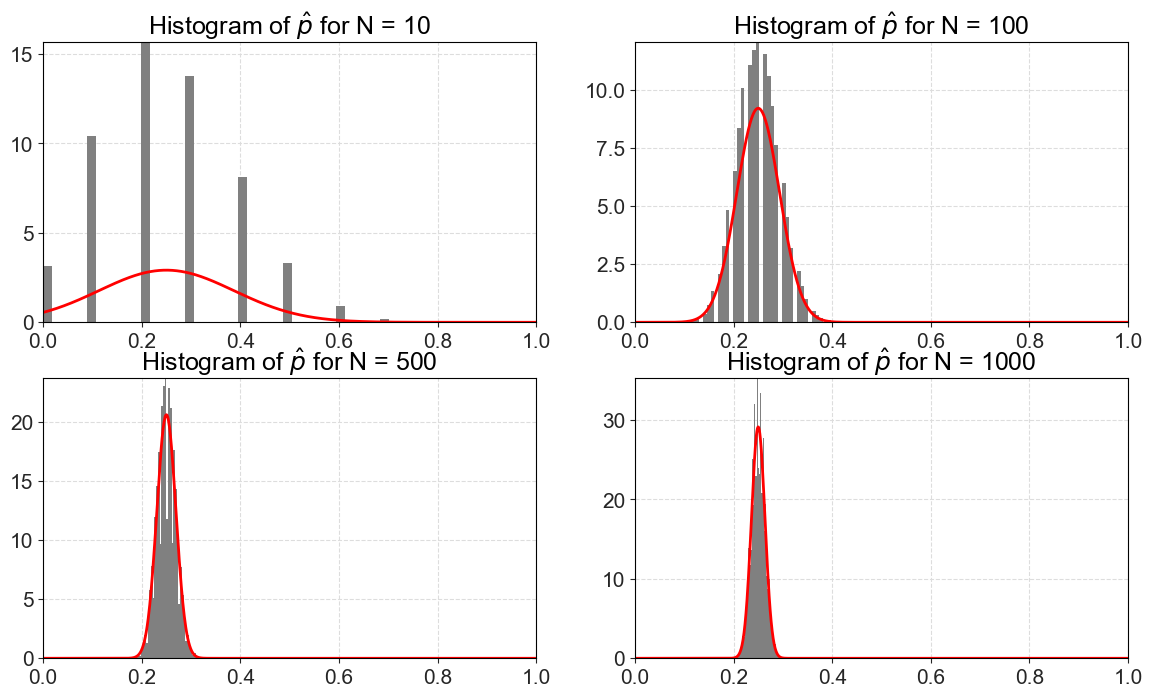

In [44]:
p = 0.25
num_sim = 100000
bernoulli_data = np.random.binomial(1,p,size=(1000, num_sim))

p_vals = np.linspace(0, 1, 1000)

fig, ax_ = plt.subplots(2,2, figsize=(14,8))
ax_ = ax_.flatten()

for i, N in enumerate([10, 100, 500, 1000]): 

    ax = ax_[i]
    
    # asymptotic variance
    asymp_est_var = p*(1 - p) / N
    
    
    # get section of generated data
    data = bernoulli_data[:N, :]
    
    # calculate sample means
    sample_means = np.mean(data, axis=0)
    
    # plot histogram 
    ax.hist(sample_means, color="gray", bins=50, zorder=1, density=True)
    ax.plot(p_vals, stats.norm.pdf(p_vals, loc=p, scale=np.sqrt(asymp_est_var)), color="red")
    
    ax.set_title("Histogram of $\hat{p}$ for N = " + str(N))
    ax.set_axisbelow(True)
    ax.set_xlim([0,1]);

## Non-linear Least Squares (NLS)

A non-linear regression model specifies the conditional mean as 

$$
\text{E}[y_i \vert \mathbf{x}_i] = g(\mathbf{x}_i; \theta)
$$

or equivalently written as (assuming that $\text{E}[\mathbf{e} \vert \mathbf{x}] = 0$)

$$
y_i = g(\mathbf{x}_i; \theta) + e_i
$$

Clearly, linear regression is the special case $g(\mathbf{x}_i; \beta) = \mathbf{x}_i^\top \beta$. 

The NLS estimator will minimize the sum of squared residuals or minimize (we can scale with $1/2$ without loss of generality)

$$
Q_n(\theta) = - \frac{1}{2n} \sum_{i=1}^n (y_i - g(\mathbf{x}_i; \theta))^2
$$

The FOC gives us 

$$
\frac{\partial Q_n(\theta)}{\partial \theta} = \frac{1}{n} \sum_{i=1}^n \frac{\partial g(\mathbf{x}_i; \theta)}{\partial \theta} (y_i - g(\mathbf{x}_i; \theta)) = \mathbf{0}
$$

or more compactly using matrix notation 

$$
\frac{\partial Q_n(\theta)}{\partial \theta} = \frac{1}{n}\frac{\partial \mathbf{g}^\top}{\partial \theta} (\mathbf{y}- \mathbf{g})
$$

For consistency of the NLS estimator, it is crucial that the mean is specified correctly. 

Assuming a covariance matrix for the errors $\text{E}[\mathbf{e} \mathbf{e}^\top \vert \mathbf{X}] = \boldsymbol{\Omega}_0$
and under regularity conditions, it will be the case that 

$$
\sqrt{n} (\hat{\theta}_{NLS} - \theta_0) \to^d N(0, \mathbf{A}_0^{-1} \mathbf{B}_0 \mathbf{A}_0^{-1})
$$

with 

$$
\begin{align}
\mathbf{A}_0 &= \text{plim} \left. \frac{1}{n} \frac{\partial \mathbf{g}^\top}{\partial \theta} \frac{\partial \mathbf{g}}{\partial \theta^\top}  \right \vert_{\theta = \theta_0}\\
\mathbf{B}_0 &= \text{plim} \left. \frac{1}{n} \frac{\partial \mathbf{g}^\top}{\partial \theta} \boldsymbol{\Omega}_0 \frac{\partial \mathbf{g}}{\partial \theta^\top} \right \vert_{\theta = \theta_0}
\end{align}
$$

A reasonable estimator for $\mathbf{A}_0$ is 

$$
\hat{\mathbf{A}} = \left. \frac{1}{n} \frac{\partial \mathbf{g}^\top}{\partial \theta} \frac{\partial \mathbf{g}}{\partial \theta^\top}\right \vert_{\theta = \hat{\theta}_{NLS}}
$$

For $\mathbf{B}_0$ it depends (just as in the OLS case) on the assumption we can make about $\boldsymbol{\Omega}_0$. Assuming independence implies that $\boldsymbol{\Omega}_0$ must be a diagonal matrix. If homoskedasticity of the error term can be assumed then 

$$
\sqrt{n} (\hat{\theta}_{NLS} - \theta_0) \to^d N(0, \sigma^2 \mathbf{A}_0^{-1})
$$

and we just need to estimate $\sigma^2$ using the sample variance. If we allow for heteroskedasticity, we can estimate 

$$
\hat{\mathbf{B}} = \left. \frac{1}{n} \frac{\partial \mathbf{g}^\top}{\partial \theta} \hat{\boldsymbol{\Omega}}\frac{\partial \mathbf{g}}{\partial \theta^\top}\right \vert_{\theta = \hat{\theta}_{NLS}}
$$

where $\hat{\boldsymbol{\Omega}} = \text{Diag}[\hat{e}_i^2]$. 




## Application: Exponential distribution 

The [exponential density](https://en.wikipedia.org/wiki/Exponential_distribution) is given by

$$
f_Y(y) = \lambda e^{-\lambda y}, \; y > 0, \; \lambda > 0
$$

The mean and variance is respectively $1/\lambda$ and $1/\lambda^2$. The exponential distribution can be used to describe the time for a continuous process to change state or for an event to occur, e.g. time between roadkills on a given road. 

Below we plot the density of a exponential density (with the above parameterization) assuming $\lambda = 12$. On average, we will wait $1/12$ time periods for one event to occur (one month if $y$ is measured in years). 

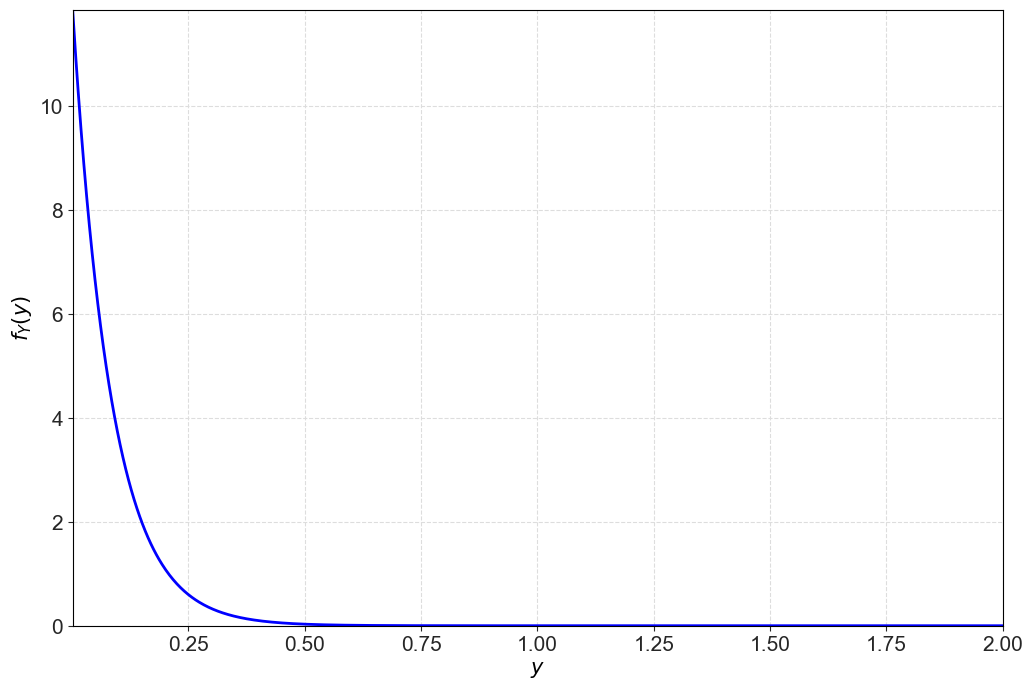

In [45]:
lam = 12.0
y_values = np.linspace(0.001, 2.0, 1000)
pdf_values = stats.expon.pdf(y_values, scale = 1 / lam)

"""
Plotting
"""

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(y_values, pdf_values, color="blue")
ax.set_xlabel('$y$');
ax.set_ylabel('$f_Y(y)$');

We may introduce explanatory variables by specifying 

$$
\lambda = e^{\mathbf{x}^\top \beta} 
$$

ensuring $\lambda > 0$ and specifying the conditional mean as 

$$
\text{E}[y \vert \mathbf{x}] = e^{-\mathbf{x}^\top \beta}
$$

Assume that we observe a realization of a iid random sample $y_i, \mathbf{x}_i$, $i = 1, ... n$. 

### The MLE 

The (conditional) log-likehood function can be written

$$
\mathcal{L}_n (\beta) =  \sum_{i=1}^n  \left[ \mathbf{x}_i^\top \beta - e^{\mathbf{x}_i^\top \beta} y_i\right]
$$

with the FOC 

$$
\frac{\partial \mathcal{L}_n (\beta)}{\partial \beta} =  \sum_{i=1}^n  \left[ \mathbf{x}_i  - \mathbf{x}_i e^{\mathbf{x}_i^\top \beta} y_i\right] = \sum_{i=1}^n  \mathbf{x}_i\left[ 1  - e^{\mathbf{x}_i^\top \beta} y_i\right] = \mathbf{0}
$$

To obtain the variance of the MLE estimator, it will be useful to note that (using the more general notation of m-estimators)

$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n  \frac{\partial^2 q_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta \partial \beta^\top} &=  \frac{1}{n} \sum_{i=1}^n -\mathbf{x}_i \mathbf{x}_i^\top e^{\mathbf{x}_i^\top \beta} y_i\\
\frac{1}{n} \sum_{i=1}^n \frac{\partial q_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta } \frac{\partial q_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta^\top }  &=      \frac{1}{n} \sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^\top \left[1 - e^{\mathbf{x}_i^\top \beta} y_i \right]^2
\end{align}
$$


### The NLS estimator

A non-linear least squares estimator can be implemented by estimating 

$$
y_i = e^{-\mathbf{x}_i^\top \beta} + e_i
$$

We also note that the error term is heteroskedastic since $\text{Var}[y_i] = 1 / [e^{\mathbf{x}_i^\top \beta}]^2$. Our FOC reads

$$
\frac{1}{n} \sum_{i=1}^n (y_i - e^{-\mathbf{x}_i^\top \beta})e^{-\mathbf{x}_i^\top \beta}\mathbf{x}_i = \mathbf{0}
$$

For calculating variance, we note that (using the notation for NLS above)

$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n \frac{\partial g_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta } \frac{\partial g_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta^\top }  &= \frac{1}{n} \sum_{i=1}^n e^{2\mathbf{x}_i^\top \beta}\mathbf{x}_i \mathbf{x}_i^\top \\
\frac{1}{n} \sum_{i=1}^n \sigma_i^2 \frac{\partial g_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta } \frac{\partial g_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta^\top }  &=  \frac{1}{n} \sum_{i=1}^n e^{-2\mathbf{x}_i^\top \beta} e^{2\mathbf{x}_i^\top \beta}\mathbf{x}_i \mathbf{x}_i^\top = \frac{1}{n} \sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^\top
\end{align}
$$

### Simulating data and implementing estimators

We consider 10,000 iid draws from the data generating process

$$
y \sim \text{Exp}(\beta_1 + \beta_2 x)
$$

with $x \sim N(1, 1)$ and $(\beta_1, \beta_2) = (2, -1)$.

#### MLE

Below we implement the (negative) log-likelhood function and minimize it.

In [46]:
"""
Simulate data
"""
n_sim = 10000

beta1 = 2
beta2 = -1.0
beta = np.array([beta1, beta2])

x_data = np.random.normal(loc=1, scale=1, size=n_sim)
x_data = np.c_[np.ones(n_sim), x_data]
y_data = np.random.exponential(scale = 1 / np.exp(x_data @ beta), size=n_sim)

In [47]:
"""
Define log-likelihood function (negative)
"""


def log_likelihood_function(beta, y, x, individual=False):
    
    log_like = x @ beta - np.exp(x @ beta) * y
    
    if individual: 
        return -log_like
    else:
        return -np.sum(log_like)

"""
Minimize negative log-likelihood 
"""
res_dict = {}
res_dict['MLE'] = {}

res = minimize(log_likelihood_function, [0.5, 0.5], args=(y_data, x_data))
res_dict['MLE']['beta1'] = res.x[0]
res_dict['MLE']['beta2'] = res.x[1]
params_mle = res.x
params_mle

array([ 1.97406571, -0.998121  ])

We have several different options when calculating the variance of the estimator. In this particular model, we know that 

$$
\begin{align}
\text{E}\left[\frac{1}{n} \sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^\top \left[1 - e^{\mathbf{x}_i^\top \beta} y_i \right]^2 \right] &= \frac{1}{n}\sum_{i=1}^n \text{E}\left[\mathbf{x}_i \mathbf{x}_i^\top \left[1 - e^{\mathbf{x}_i^\top \beta} y_i \right]^2 \right] \\
        & = \frac{1}{n}\sum_{i=1}^n \text{E}\left[\mathbf{x}_i \mathbf{x}_i^\top \right]\\
\text{E}\left[ \frac{1}{n} \sum_{i=1}^n -\mathbf{x}_i \mathbf{x}_i^\top e^{\mathbf{x}_i^\top \beta} y_i \right] &= -\frac{1}{n}\sum_{i=1}^n \text{E}\left[\mathbf{x}_i \mathbf{x}_i^\top \right]
\end{align}
$$

Given our assumptions about $x$, we know that 

$$
\text{E}\left[\mathbf{x}_i \mathbf{x}_i^\top \right] = \text{E}\left[\begin{bmatrix} 1 \\ x_i \end{bmatrix} \begin{bmatrix} 1 & x_i \end{bmatrix} \right] = \text{E}\left[\begin{bmatrix} 1 & x_i \\ x_i & x_i^2 \end{bmatrix} \right] = \begin{bmatrix} 1 & 1 \\ 1 & 2 \end{bmatrix} 
$$

such that the variance is given by

$$
\text{Var}[\hat{\beta}] = - \left[-n \text{E}\left[\mathbf{x}_i \mathbf{x}_i^\top \right]\right]^{-1}
$$

In [48]:
exp_xx_true = np.array([[1, 1], [1, 2]])
param_mle_cov_true = np.linalg.inv(n_sim * exp_xx_true)

res_dict['MLE']['std1_true'] = np.sqrt(param_mle_cov_true[0,0])
res_dict['MLE']['std2_true'] = np.sqrt(param_mle_cov_true[1,1])

# print covariance matrix of parameter estimator 
param_mle_cov_true

array([[ 0.0002, -0.0001],
       [-0.0001,  0.0001]])

Generally, we observe real data, i.e. we do not know the true data generating process, such that we need to estimate the variance of the estimator. We need to evaluate the below expression at the MLE estimate. 


$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n  \frac{\partial^2 q_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta \partial \beta^\top} &= \frac{1}{n} \sum_{i=1}^n -\mathbf{x}_i \mathbf{x}_i^\top e^{\mathbf{x}_i^\top \beta} y_i \\
\frac{1}{n} \sum_{i=1}^n \frac{\partial q_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta } \frac{\partial q_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta^\top }  &=     \frac{1}{n} \sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^\top \left[1 - e^{\mathbf{x}_i^\top \beta} y_i \right]^2
\end{align}
$$

To calculate the above expressions, we need to calculate $\mathbf{x}_i \mathbf{x}_i^\top$ for each $i$. A quick way is to use the `numpy.einsum` function. 

In [49]:
x_data.shape

(10000, 2)

In [50]:
np.einsum('ji,jk->jik', x_data, x_data).shape

(10000, 2, 2)

In [51]:
np.sum(np.einsum('ji,jk->jik',x_data, x_data), axis=0) / n_sim

array([[1.        , 0.99410324],
       [0.99410324, 1.98160959]])

In [52]:
np.einsum('ji,jk->ik',x_data, x_data) / n_sim

array([[1.        , 0.99410324],
       [0.99410324, 1.98160959]])

In [53]:
np.sum(np.einsum('ji,kj->jik',x_data, x_data.T), axis=0) / n_sim

array([[1.        , 0.99410324],
       [0.99410324, 1.98160959]])

In [54]:
np.einsum('ji,kj->ik',x_data, x_data.T) / n_sim

array([[1.        , 0.99410324],
       [0.99410324, 1.98160959]])

In [55]:
x_data.T @ x_data / n_sim

array([[1.        , 0.99410324],
       [0.99410324, 1.98160959]])

In [56]:
"""
Gradient 
"""

def outer_gradient(beta, x, y): 
    
    return np.sum(((1 - np.exp(x @ beta) * y)**2)[:, None, None] * np.einsum('ji,jk->jik',x, x), axis=0)

def outer_gradient_alternative(beta, x, y): 
    
    x_new = (1 - np.exp(x @ beta) * y)[:, None] * x
    
    return x_new.T @ x_new

"""
Hessian 
"""

def hessian(beta, x, y): 
    
    return -np.sum((np.exp(x_data @ beta) * y)[:, None, None] * 
                   np.einsum('ji,jk->jik',x, x), axis=0) 
    

In [57]:
outer_gradient(params_mle, x_data, y_data)

array([[10034.54042534, 10117.18364944],
       [10117.18364944, 19512.07527266]])

In [58]:
outer_gradient_alternative(params_mle, x_data, y_data)

array([[10034.54042534, 10117.18364944],
       [10117.18364944, 19512.07527266]])

In [59]:
A = hessian(params_mle, x_data, y_data)
B = outer_gradient(params_mle, x_data, y_data)

param_mle_cov_A = np.linalg.inv(-A)
res_dict['MLE']['std1_A'] = np.sqrt(param_mle_cov_A[0,0])
res_dict['MLE']['std2_A'] = np.sqrt(param_mle_cov_A[1,1])

param_mle_cov_B = np.linalg.inv(B)
res_dict['MLE']['std1_B'] = np.sqrt(param_mle_cov_B[0,0])
res_dict['MLE']['std2_B'] = np.sqrt(param_mle_cov_B[1,1])

param_mle_cov_sandwich = np.linalg.inv(A) @ B @ np.linalg.inv(A)
res_dict['MLE']['std1_SW'] = np.sqrt(param_mle_cov_sandwich[0,0])
res_dict['MLE']['std2_SW'] = np.sqrt(param_mle_cov_sandwich[1,1])

In [60]:
# covariance matrix based on A
param_mle_cov_A

array([[ 0.00020101, -0.00010161],
       [-0.00010161,  0.00010221]])

In [61]:
# covariance matrix based on B
param_mle_cov_B

array([[ 0.00020883, -0.00010828],
       [-0.00010828,  0.00010739]])

In [62]:
# covariance matrix based on A^{-1}BA^{-1} "Sandwich formula"
param_mle_cov_sandwich

array([[ 1.93622031e-04, -9.52794412e-05],
       [-9.52794412e-05,  9.73027360e-05]])

The above calculations assume that we have derived the formula for "A" and "B" such that we "just" need to evaluate at the MLE estimate. 

However, it may be a tedious task. A common approach is to use numerical derivatives or other tools to calculate "A" and "B". Below we use the `statsmodels.tools.numdiff` package.  



In [63]:
scores = approx_fprime(params_mle, log_likelihood_function, args=(y_data, x_data, True))
B_approx = scores.T @ scores  #np.sum(np.einsum('ji,jk->jik', scores, scores), axis=0)

A_approx = -approx_hess(params_mle, log_likelihood_function, args=(y_data, x_data))

param_mle_cov_A_num = np.linalg.inv(-A_approx)
res_dict['MLE']['std1_A_num'] = np.sqrt(param_mle_cov_A_num[0,0])
res_dict['MLE']['std2_A_num'] = np.sqrt(param_mle_cov_A_num[1,1])

param_mle_cov_B_num = np.linalg.inv(B_approx)
res_dict['MLE']['std1_B_num'] = np.sqrt(param_mle_cov_B_num[0,0])
res_dict['MLE']['std2_B_num'] = np.sqrt(param_mle_cov_B_num[1,1])

param_mle_cov_sandwich_num = np.linalg.inv(A_approx) @ B_approx @ np.linalg.inv(A_approx)
res_dict['MLE']['std1_SW_num'] = np.sqrt(param_mle_cov_sandwich_num[0,0])
res_dict['MLE']['std2_SW_num'] = np.sqrt(param_mle_cov_sandwich_num[1,1])

In [64]:
# covariance matrix based on A
param_mle_cov_A_num

array([[ 0.00020101, -0.00010161],
       [-0.00010161,  0.00010221]])

In [65]:
# covariance matrix based on B
param_mle_cov_B_num

array([[ 0.00020883, -0.00010828],
       [-0.00010828,  0.00010739]])

In [66]:
# covariance matrix based on A^{-1}BA^{-1} "Sandwich formula"
param_mle_cov_sandwich_num

array([[ 1.93622026e-04, -9.52794384e-05],
       [-9.52794384e-05,  9.73027335e-05]])

In [67]:
res_dict

{'MLE': {'beta1': 1.974065709612816,
  'beta2': -0.9981209985685346,
  'std1_true': 0.01414213562373095,
  'std2_true': 0.01,
  'std1_A': 0.014177824105037241,
  'std2_A': 0.010110024180257087,
  'std1_B': 0.014450789801812617,
  'std2_B': 0.010363073920632687,
  'std1_SW': 0.013914813349370636,
  'std2_SW': 0.009864214922529745,
  'std1_A_num': 0.014177823932659334,
  'std2_A_num': 0.010110024033479876,
  'std1_B_num': 0.014450789619739403,
  'std2_B_num': 0.010363073754433506,
  'std1_SW_num': 0.013914813186889164,
  'std2_SW_num': 0.009864214794856678}}

We have specified the model correctly and have lots of data, so it is no surprice that maximum likelihood performs well. Due to the information matrix equality, then using different variance estimators gives us very similar results. 

#### NLS

Next, we define the NLS objective and minimze it. 

In [68]:
def objective_nls(beta, y, x, individual=False): 
    
    loss = np.square(y - np.exp(-x @ beta)) 
    
    if individual: 
        return loss
    else:
        return np.sum(loss) / len(y)
    
def foc_nls(beta, y, x): 
    
    der = (y - np.exp(-x @ beta)) * np.exp(-x @ beta) @ x

    return np.sum(der)


In [69]:
res_dict['NLS'] = {}

res = minimize(objective_nls, [1.0, -2.0], args=(y_data, x_data, False))
res_dict['NLS']['beta1'] = res.x[0]
res_dict['NLS']['beta2'] = res.x[1]
params_nls = res.x
params_nls

array([ 1.99151912, -0.99323457])

In [70]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.8193158607208716
        x: [ 1.992e+00 -9.932e-01]
      nit: 25
      jac: [-1.490e-07 -5.960e-07]
 hess_inv: [[ 6.573e+00 -2.091e+00]
            [-2.091e+00  7.248e-01]]
     nfev: 81
     njev: 27

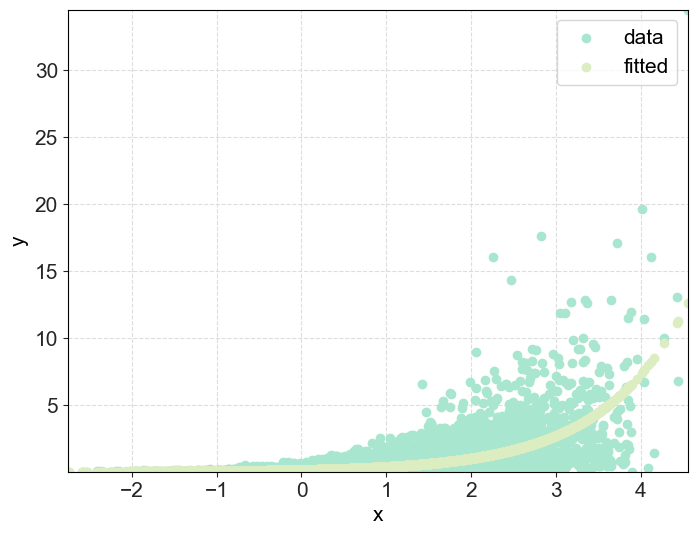

In [71]:
"""
Clearly the error term is heteroskedastic...
"""
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x_data[:, 1], y_data, label="data")
ax.scatter(x_data[:, 1],  np.exp(-x_data @ params_nls), label="fitted")

ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)

ax.legend();

Next step is to calculate the variance of the NLS estimator. Again, we can either use the exact analytical expressions or use numerical derivatives. We consider the analytical derivatives. 

We implement 

$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n \frac{\partial g_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta } \frac{\partial g_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta^\top }  &= \frac{1}{n} \sum_{i=1}^n e^{2\mathbf{x}_i^\top \beta}\mathbf{x}_i \mathbf{x}_i^\top \\
\frac{1}{n} \sum_{i=1}^n \sigma_i^2 \frac{\partial g_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta } \frac{\partial g_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta^\top }  &=  \frac{1}{n} \sum_{i=1}^n e^{-2\mathbf{x}_i^\top \beta} e^{2\mathbf{x}_i^\top \beta}\mathbf{x}_i \mathbf{x}_i^\top = \frac{1}{n} \sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^\top
\end{align}
$$

In [72]:
def calculate_scores_g(beta: np.ndarray, y: np.ndarray, x: np.ndarray) -> np.ndarray:
    
    """
    Calculates the score
    """
    
    return np.exp(-x @ beta)[:, None] * x

In [73]:
scores_g = calculate_scores_g(params_nls, y_data, x_data)

In [74]:
A = scores_g.T @ scores_g
B = scores_g.T @ np.diag(np.exp(-2*x_data @ params_nls)) @ scores_g
B_alt = scores_g.T @ np.diag((y_data - np.exp(-x_data @ params_nls) )**2) @ scores_g

In [75]:
param_nls_cov_A = np.linalg.inv(A) #<-- understates variance
res_dict['NLS']['std1_A'] = np.sqrt(param_nls_cov_A[0,0])
res_dict['NLS']['std2_A'] = np.sqrt(param_nls_cov_A[1,1])

param_nls_cov_B = np.linalg.inv(B) #<-- understates variance
res_dict['NLS']['std1_B'] = np.sqrt(param_nls_cov_B[0,0])
res_dict['NLS']['std2_B'] = np.sqrt(param_nls_cov_B[1,1])

param_nls_cov_sandwich = np.linalg.inv(A) @ B @ np.linalg.inv(A) #<-- valid estimator due to heteroskedasticity
res_dict['NLS']['std1_SW'] = np.sqrt(param_nls_cov_sandwich[0,0])
res_dict['NLS']['std2_SW'] = np.sqrt(param_nls_cov_sandwich[1,1])

In [76]:
param_nls_cov_A

array([[ 0.00122853, -0.00038932],
       [-0.00038932,  0.00013536]])

In [77]:
param_nls_cov_B

array([[ 2.97365071e-04, -7.42795751e-05],
       [-7.42795751e-05,  1.89196743e-05]])

In [78]:
param_nls_cov_sandwich

array([[ 0.02368708, -0.01021187],
       [-0.01021187,  0.00448676]])

In [79]:
res_dict

{'MLE': {'beta1': 1.974065709612816,
  'beta2': -0.9981209985685346,
  'std1_true': 0.01414213562373095,
  'std2_true': 0.01,
  'std1_A': 0.014177824105037241,
  'std2_A': 0.010110024180257087,
  'std1_B': 0.014450789801812617,
  'std2_B': 0.010363073920632687,
  'std1_SW': 0.013914813349370636,
  'std2_SW': 0.009864214922529745,
  'std1_A_num': 0.014177823932659334,
  'std2_A_num': 0.010110024033479876,
  'std1_B_num': 0.014450789619739403,
  'std2_B_num': 0.010363073754433506,
  'std1_SW_num': 0.013914813186889164,
  'std2_SW_num': 0.009864214794856678},
 'NLS': {'beta1': 1.991519117054412,
  'beta2': -0.9932345720764394,
  'std1_A': 0.03505044393295066,
  'std2_A': 0.011634414695600002,
  'std1_B': 0.017244276461204945,
  'std2_B': 0.004349675189700967,
  'std1_SW': 0.15390608613467535,
  'std2_SW': 0.06698330130296873}}

## Estimation using SciPy

`scipy` provides MLE methods for implemented distributions (see e.g. [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html)). For instance, we can fit the parameters of a normal distribution. 

In [80]:
"""
Simulate Normal data and estimate parameters
"""

num_sim = 10000
sigma = 1
mu = 5


norm_data = np.random.normal(loc=mu, scale=sigma, size=num_sim)

# Known MLE 
mu_est = np.mean(norm_data)
variance_est = np.var(norm_data)
sigma_est = np.sqrt(variance_est)

print("MLE mu: " + str(mu_est))
print("MLE std: " + str(sigma_est) + "\n")

# fit using SciPy
mu_scipy_est, sigma_scipy_est = stats.norm.fit(norm_data)

print("SciPy mu: " + str(mu_scipy_est))
print("SciPy std: " + str(sigma_scipy_est))

MLE mu: 5.0137913124204605
MLE std: 1.0142671692558516

SciPy mu: 5.0137913124204605
SciPy std: 1.0142671692558516


## Estimation using Statsmodels

`scipy` provides a quick MLE implementation for different distributions, but may not be applicable for more complicated problem. 

`statsmodels` provides a framework for implementing generic MLE estimators (see [docs](https://www.statsmodels.org/dev/examples/notebooks/generated/generic_mle.html)). Let us try to implement our exponential model using `statsmodels`!

In [81]:
from statsmodels.base.model import GenericLikelihoodModel

# overwrite loglikelihood function in Generic Likelihood Class
class Exponential(GenericLikelihoodModel):
    
    def loglike(self, params):
        exog = self.exog
        endog = self.endog
        return (exog @ params - np.exp(exog @ params) * endog).sum()

# fit models
exponential_fit = Exponential(y_data, x_data).fit()

# print results
print(exponential_fit.summary())

Optimization terminated successfully.
         Current function value: 0.018170
         Iterations: 52
         Function evaluations: 99
                             Exponential Results                              
Dep. Variable:                      y   Log-Likelihood:                -181.70
Model:                    Exponential   AIC:                             367.4
Method:            Maximum Likelihood   BIC:                             381.8
Date:                Sat, 26 Aug 2023                                         
Time:                        15:34:45                                         
No. Observations:               10000                                         
Df Residuals:                    9998                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

In [82]:
"""
Our previous estimates
"""

params_mle

array([ 1.97406571, -0.998121  ])

# References

## Books

 [Microeconometrics: Methods and Applications, Cameron and Trivedi (2005)](https://www.cambridge.org/highereducation/books/microeconometrics/982158DE989697607C858068ED05C7B1#overview)
 
 [Econometric Analysis 7th edition, William H. Greene (2012)](https://www.amazon.com/Econometric-Analysis-7th-William-Greene/dp/0131395386)
